In [1]:
import os
import numpy as np
import random
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 指定文件夹路径
# download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
# download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
# download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

# 指定工作文件夹
work_folder_path = exception_folder_paths[3]

# 指定工作mat名称
work_mat_name = os.listdir(work_folder_path)[8]
''' 用[3][2]做train, [3][8]做test
'[0][4]': 652200104170943.mat, 
'[1][0]': 652200108141328.mat, '[1][2]': 652200109050955.mat, '[1][3]': 652200109121214.mat, 
'[3][0]':652200204060950.mat, '[3][2]':652200204251941.mat, '[3][3]':652200205021804.mat, '[3][8]':652200206071302.mat
'''

# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [17]:
from sklearn.preprocessing import StandardScaler

def dataSampling(var_data, var_rate, wshr_data):
    # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
    if var_rate == 1:
        sampling_data = var_data
    else: # 进行重采样
        sampling_data = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]
    # # 将采样数据进行min_max归一化
    # if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
    #     sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
    # else:
    #     sampling_data = sampling_data
    return sampling_data

def dataConstruct(work_folder_path, work_mat_name, is_all_variable = False):
    # 读取工作mat
    work_mat = loadmat(os.path.join(work_folder_path, work_mat_name))

    # 初始化采样数据list
    sampling_data_list = []
    wshr_data = work_mat["WSHR"][0][0][0]

    if not is_all_variable:
        # 提取WS, WD, TAS并进行重采样
        variable_list = ["WS", "WD", "TAS"]
        for var_name in variable_list:
            var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
            sampling_data = dataSampling(var_data, var_rate, wshr_data)
            # print(np.max(sampling_data), np.min(sampling_data))
            sampling_data_list.append(sampling_data)
    else:
        for var_list in var_groups_dict.values():
            for var_name in var_list:
                var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
                sampling_data = dataSampling(var_data, var_rate, wshr_data)
                # print(np.max(sampling_data), np.min(sampling_data))
                sampling_data_list.append(sampling_data)
        sampling_data_list = np.squeeze(np.array(sampling_data_list))

    # 生成解释变量X和分类变量Y
    X = np.squeeze(np.array(sampling_data_list)).T
    Y = np.array(wshr_data).reshape(-1,1)
    # 数据标准化
    s_scaler = StandardScaler()
    X = s_scaler.fit_transform(X)
    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # print(X.shape, Y.shape)
    print(f"Wind Shear Warns at time {wshr_class_idx[0]}")

    if not is_all_variable:
        # 绘制X的时间变化
        plt.figure()
        plt.plot(range(len(wshr_data)), X[:, 0], label='Wind Speed')
        plt.plot(range(len(wshr_data)), X[:, 1], label='Wind Direction')
        plt.plot(range(len(wshr_data)), X[:, 2], label='True Air Speed')
        plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
        plt.xlabel('time(s)')
        plt.ylabel('WS/WD/TAS & WSHR')
        plt.title('Normalized WS/WD/TAS and WSHR')
        plt.legend()
        # if np.std(X[:, 2]) > 1e-1:
        #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
        plt.show()

        # 绘制X的三维散点图
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
        ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
        ax.set_xlabel(variable_list[0])
        ax.set_ylabel(variable_list[1])
        ax.set_zlabel(variable_list[2])
        ax.legend()
        plt.tight_layout()
        plt.show()

    return X, Y

In [5]:
from sklearn.preprocessing import StandardScaler

def dataSampling_2(var_data, var_rate, wshr_data, sampling_idx_list):
    # 对每个变量按照rate进行下采样或过采样
    if var_rate == 1:
        sampling_data = var_data
    else: # 进行重采样
        sampling_data = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]
    selected_sampling_data = []
    for i in sampling_idx_list:
        selected_sampling_data.append(sampling_data[i])
    # # 将采样数据进行min_max归一化
    # if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
    #     sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
    # else:
    #     sampling_data = sampling_data
    return selected_sampling_data

def dataConstruct_2(work_folder_path, work_mat_name, is_all_variable = False):
    # 读取工作mat
    work_mat = loadmat(os.path.join(work_folder_path, work_mat_name))

    # 初始化采样数据list
    sampling_data_list = []
    wshr_data = work_mat["WSHR"][0][0][0]
    wshr_warn_idx_list = np.where(wshr_data == 0)[0]
    sampling_idx_list = []
    for idx in wshr_warn_idx_list:
        for i in range(max(idx-15, 0), min(idx+15, len(wshr_data)-1)+1):
            sampling_idx_list.append(i)
    sampling_idx_list = list(set(sampling_idx_list))
    # print(wshr_warn_idx_list)
    # print(sampling_idx_list)

    if not is_all_variable:
        # 提取WS, WD, TAS并进行重采样
        variable_list = ["WS", "WD", "TAS"]
        for var_name in variable_list:
            var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
            sampling_data = dataSampling_2(var_data, var_rate, wshr_data)
            # print(np.max(sampling_data), np.min(sampling_data))
            sampling_data_list.append(sampling_data)
    else:
        for var_list in var_groups_dict.values():
            for var_name in var_list:
                var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
                sampling_data = dataSampling_2(var_data, var_rate, wshr_data, sampling_idx_list)
                # print(np.max(sampling_data), np.min(sampling_data))
                sampling_data_list.append(sampling_data)
        # sampling_data_list = np.squeeze(np.array(sampling_data_list))

    # 生成解释变量X和分类变量Y
    # for data in sampling_data_list:
    #     print(len(data))
    X = np.squeeze(np.array(sampling_data_list)).T
    Y = np.array(wshr_data[sampling_idx_list]).reshape(-1,1)
    # 数据标准化
    s_scaler = StandardScaler()
    X = s_scaler.fit_transform(X)

    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # print(X.shape, Y.shape)
    print(f"Wind Shear Warns at time {wshr_class_idx[0]}")

    if not is_all_variable:
        # 绘制X的时间变化
        plt.figure()
        plt.plot(range(len(wshr_data)), X[:, 0], label='Wind Speed')
        plt.plot(range(len(wshr_data)), X[:, 1], label='Wind Direction')
        plt.plot(range(len(wshr_data)), X[:, 2], label='True Air Speed')
        plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
        plt.xlabel('time(s)')
        plt.ylabel('WS/WD/TAS & WSHR')
        plt.title('Normalized WS/WD/TAS and WSHR')
        plt.legend()
        # if np.std(X[:, 2]) > 1e-1:
        #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
        plt.show()

        # 绘制X的三维散点图
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
        ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
        ax.set_xlabel(variable_list[0])
        ax.set_ylabel(variable_list[1])
        ax.set_zlabel(variable_list[2])
        ax.legend()
        plt.tight_layout()
        plt.show()

    return X, Y

In [6]:
''' 用[3][2]做train, [3][8]做test
'[0][4]': 652200104170943.mat, 
'[1][0]': 652200108141328.mat, '[1][2]': 652200109050955.mat, '[1][3]': 652200109121214.mat, 
'[3][0]':652200204060950.mat, '[3][2]':652200204251941.mat, '[3][3]':652200205021804.mat, '[3][8]':652200206071302.mat
'''
# for path in exception_folder_paths[:10]:
#     for mat_name in os.listdir(path):
#         dataConstruct(path, mat_name)

" 用[3][2]做train, [3][8]做test\n'[0][4]': 652200104170943.mat, \n'[1][0]': 652200108141328.mat, '[1][2]': 652200109050955.mat, '[1][3]': 652200109121214.mat, \n'[3][0]':652200204060950.mat, '[3][2]':652200204251941.mat, '[3][3]':652200205021804.mat, '[3][8]':652200206071302.mat\n"

Wind Shear Warns at time [938 939 940 941 942 943]


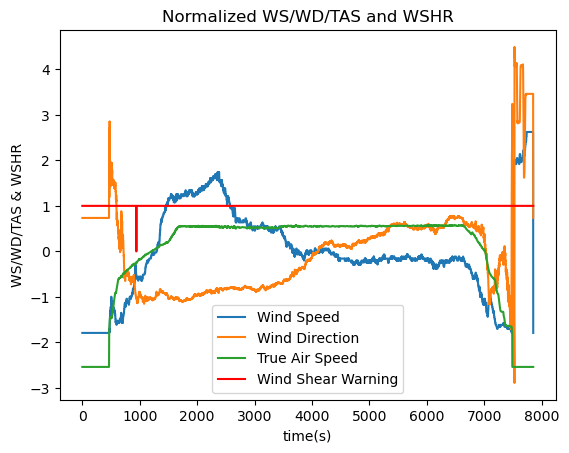

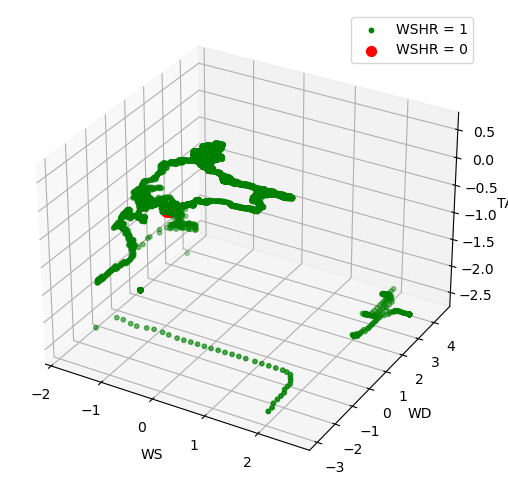

Wind Shear Warns at time [2289 2290 2291 2292 2293 2294 2295]


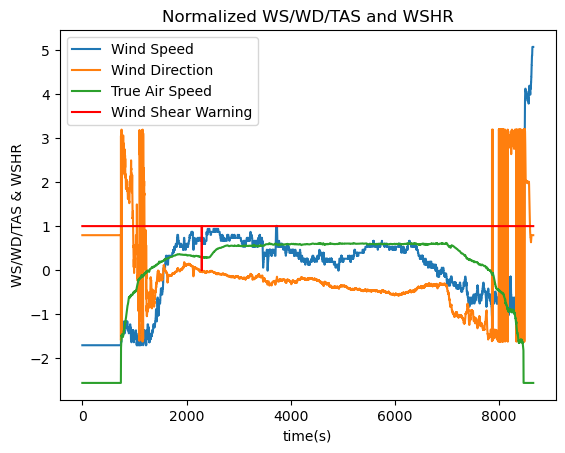

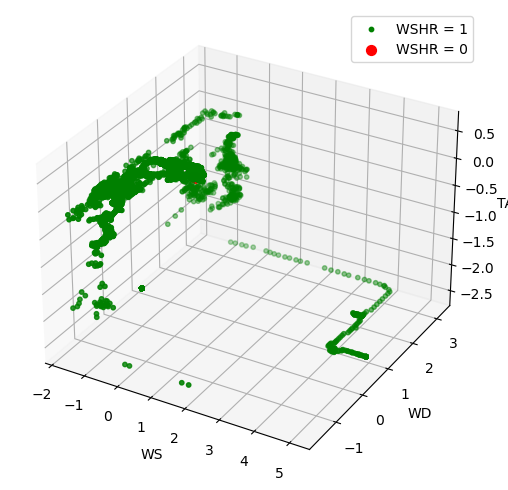

d:\Coding\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

Accuracy: 99.76%
Accuracy: 99.72%
Accuracy: 99.79%
Accuracy: 99.92%
Accuracy: 99.92%
Accuracy: 99.92%
Accuracy: 99.92%


d:\Coding\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Coding\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 99.92%
Accuracy: 99.92%


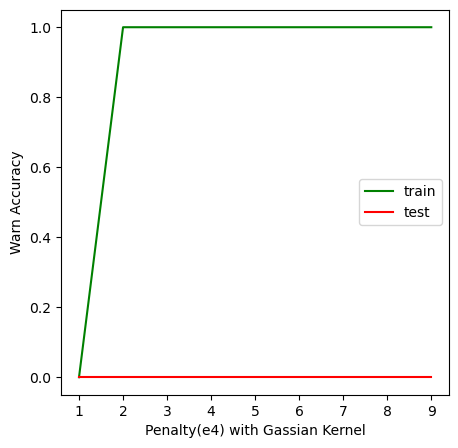

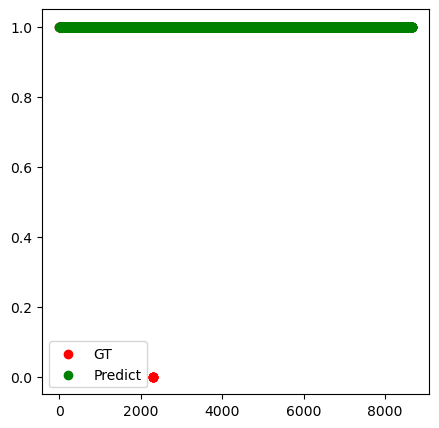

In [18]:
# SVM 二分类
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 创建支持向量机模型并进行训练
''' kernel & C : accuracy 在[3][2]上的分类效果：
rbf & 7e4: 99.94% # 50%异常识别率
rbf & 1e5: 99.96% # 100% 异常识别率
rbf & 1e6: 99.97%
poly & 7e4: 99.97% # 分类效果最好
sigmoid & 1e2: 99.91% 没有分类效果
'''

''' kernel & C : accuracy 在[3][8]上的分类效果：
rbf & 1e10: 99.92% # 没有分类效果
poly & 1e10: 99.91% # 没有分类效果
sigmoid & 1e2: 99.05% 没有分类效果
'''

# ===== 对WS, WD, TAS做SVM ===== 

# 构建训练和测试数据集
train_X, train_Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2])
# train_X_all, train_Y_all = [], []
# for i, mat_name in enumerate(os.listdir(exception_folder_paths[0])):
#     # if i == test_idx:
#     #     continue
#     # print(mat_name)
#     train_X, train_Y = dataConstruct_2(exception_folder_paths[0], mat_name, is_all_variable=True)
#     train_X_all.append(train_X)
#     train_Y_all.append(train_Y)

# train_X, train_Y = np.concatenate(train_X_all, axis=0), np.concatenate(train_Y_all, axis=0)

test_X, test_Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[8])

train_warn_GT_list = [938, 939, 940, 941, 942, 943]
test_warn_GT_list = [2289, 2290, 2291, 2292, 2293, 2294, 2295]
train_warn_pred_list, test_warn_pred_list = [], []

# # 读取聚类标签
# cluster_labels = np.load('../result/variable_clustering/DBSCAN/cluster_labels_e[3][2].npy')
# # 抽取训练集中的有效数据
# train_X, train_Y = train_X[cluster_labels == 2-1], train_Y[cluster_labels == 2-1]

for penalty in range(1, 10):
# for penalty in [7]:
    model = SVC(C=penalty*1e4, kernel='rbf')  # 选择高斯核函数
    # model = SVC(C=penalty*1e6, kernel='poly')  # 选择三次多项式核函数，计算速度很慢，效果也不是很好
    # model = SVC(C=1e2, kernel='sigmoid') # 选择sigmoid核函数，效果最差

    # 训练过程
    model.fit(train_X, train_Y)
    Y_pred = model.predict(train_X)
    # for i in train_warn_GT_list:
    #     print(train_Y[i], Y_pred[i])
    train_warn_pred_list.append(1 - sum(Y_pred[train_warn_GT_list])/len(train_warn_GT_list))

    # 在测试集上进行预测
    Y_pred = model.predict(test_X)
    # for i in test_warn_GT_list:
    #     print(test_Y[i], Y_pred[i])
    test_warn_pred_list.append(1 - sum(Y_pred[test_warn_GT_list])/len(test_warn_GT_list))

    # 计算准确率
    accuracy = accuracy_score(test_Y, Y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

# 拟合表现可视化
plt.figure(figsize=(5, 5))
plt.plot(range(1, len(train_warn_pred_list)+1), train_warn_pred_list, 'g-', label='train')
plt.plot(range(1, len(test_warn_pred_list)+1), test_warn_pred_list, 'r-', label='test')
plt.xlabel('Penalty(e4) with Gassian Kernel')
plt.ylabel('Warn Accuracy')
plt.legend()
plt.show()

# 绘制真实-预测散点图
plt.figure(figsize=(5, 5))
plt.scatter(range(len(test_Y)), test_Y, c='red', label='GT')
plt.scatter(range(len(Y_pred)), Y_pred, c='green', label='Predict')
plt.legend()
plt.show()

# # ===== 对全变量做SVM ===== 

# # 构建训练和测试数据集
# train_X, train_Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], is_all_variable=True)
# test_X, test_Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[8], is_all_variable=True)

# train_warn_GT_list = [938, 939, 940, 941, 942, 943]
# test_warn_GT_list = [2289, 2290, 2291, 2292, 2293, 2294, 2295]
# train_warn_pred_list, test_warn_pred_list = [], []
# for penalty in range(1, 10):
#     model = SVC(C=penalty*1e6, kernel='rbf')  # 选择高斯核函数
#     # model = SVC(C=7e4, kernel='poly')  # 选择三次多项式核函数
#     # model = SVC(C=1e2, kernel='sigmoid') # 选择sigmoid核函数
#     model.fit(train_X, train_Y)
#     Y_pred = model.predict(train_X)
#     # for i in train_warn_GT_list:
#     #     print(train_Y[i], Y_pred[i])
#     train_warn_pred_list.append(1 - sum(Y_pred[train_warn_GT_list])/len(train_warn_GT_list))

#     # 在测试集上进行预测
#     Y_pred = model.predict(test_X)
#     # for i in test_warn_GT_list:
#     #     print(test_Y[i], Y_pred[i])
#     test_warn_pred_list.append(1 - sum(Y_pred[test_warn_GT_list])/len(test_warn_GT_list))

#     # 计算准确率
#     accuracy = accuracy_score(test_Y, Y_pred)
#     print("Accuracy: {:.2f}%".format(accuracy * 100))

# # 拟合表现可视化
# plt.figure(figsize=(5, 5))
# plt.plot(range(1, 10), train_warn_pred_list, 'g-', label='train')
# plt.plot(range(1, 10), test_warn_pred_list, 'r-', label='test')
# plt.xlabel('Penalty(e6) with Gassian Kernel')
# plt.ylabel('Warn Accuracy')
# plt.legend()
# plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(46248, 90) (46248, 1) (779,)
0.004901960784313708


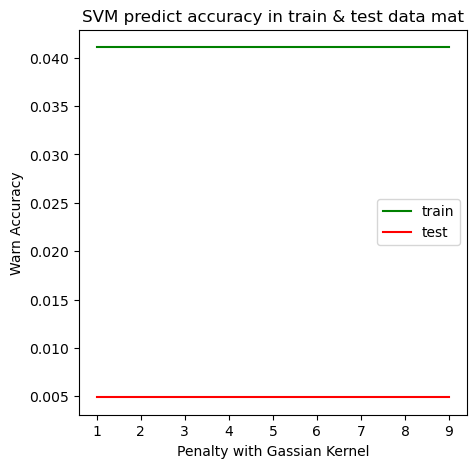

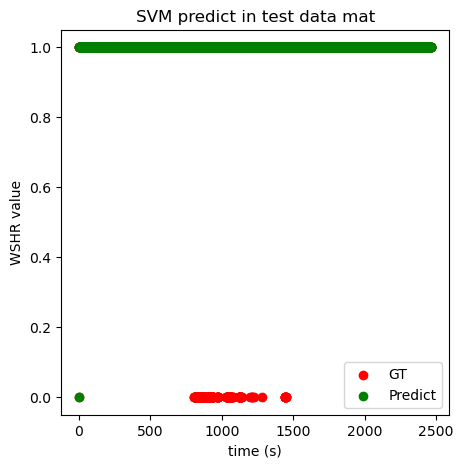

In [15]:
%load_ext autoreload
%autoreload 1
%aimport wshrRelabelLight

# SVM 二分类
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import wshrRelabelLight as WRL
import os

# 创建支持向量机模型并进行训练

# ===== 对包含ALTR和PTCH在内的部分变量做SVM ===== 

# variable_list = ['ALTR', 'PTCH', "ALT", 'PT', 'AOA1', 'AOA2', 'WS', "WD", "TAS", "GS"]
# variable_list = ['ALTR', 'PTCH', "ALT", 'AOA1', 'AOA2', 'WS', "WD", "TAS", "GS"]
variable_list = []
for group_name, var_list in var_groups_dict.items():
    '''
    单组贡献：mechanism(0.035) > control(0.025) > external(0.005) > power(0)
    双组贡献：control和external加入都会略微削弱mechanism贡献(-0.001)
    三组贡献：0.033
    '''
    # if group_name in ["mechanism", "power", "control", "external"]:
    if group_name in ["mechanism", "control", "external"]:
        variable_list.extend(var_list)
if 'ALTR' in variable_list:
    variable_list.remove('ALTR')
if 'PTCH' in variable_list:
    variable_list.remove('PTCH')
variable_list.insert(0, 'ALTR')
variable_list.insert(1, 'PTCH')

# 构建训练和测试数据集
# train_folder_name, train_mat_name = exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2]
# train_X, train_Y = WRL.dataConstruct(train_folder_name, train_mat_name, \
#                                     variable_list, normalized=True)
# train_cross_OOC_idx_list = WRL.crossValidate(train_folder_name, train_mat_name, variable_list)
# train_Y = np.array([0 if i in train_cross_OOC_idx_list or train_Y[i] == 0 else 1 for i in range(len(train_Y))]).reshape(-1,1)
# train_warn_GT_list = np.where(train_Y == 0)[0]
train_X_all, train_Y_all = [], []
train_warn_GT_list_all = []
for idx in range(3):
    train_folder_name = exception_folder_paths[idx]
    for train_mat_name in os.listdir(train_folder_name):
        train_X, train_Y = WRL.dataConstruct(train_folder_name, train_mat_name, \
                                            variable_list, normalized=True)
        train_cross_OOC_idx_list = WRL.crossValidate(train_folder_name, train_mat_name, variable_list)
        train_Y = np.array([0 if i in train_cross_OOC_idx_list or train_Y[i] == 0 else 1 for i in range(len(train_Y))]).reshape(-1,1)
        train_warn_GT_list = np.where(train_Y == 0)[0]

        train_X_all.append(train_X)
        train_Y_all.append(train_Y)
        train_warn_GT_list_all.append(train_warn_GT_list)
train_X_all = np.concatenate(train_X_all, axis=0)
train_Y_all = np.concatenate(train_Y_all, axis=0)
train_warn_GT_list_all = np.concatenate(train_warn_GT_list_all, axis=0)
# print(train_X_all.shape, train_Y_all.shape, train_warn_GT_list_all.shape)

test_folder_name, test_mat_name = exception_folder_paths[9], os.listdir(exception_folder_paths[9])[7]
test_X, test_Y = WRL.dataConstruct(train_folder_name, train_mat_name, \
                                     variable_list, normalized=True)
test_cross_OOC_idx_list = WRL.crossValidate(test_folder_name, test_mat_name, variable_list)
test_Y = np.array([0 if i in test_cross_OOC_idx_list or test_Y[i] == 0 else 1 for i in range(len(test_Y))]).reshape(-1,1)
test_warn_GT_list = np.where(test_Y == 0)[0]

train_warn_pred_list, test_warn_pred_list = [], []

for penalty in range(1, 10):
# for penalty in [7]:
    model = SVC(C=penalty, kernel='rbf')  # 选择高斯核函数
    # model = SVC(C=penalty*1e6, kernel='poly')  # 选择三次多项式核函数，计算速度很慢，效果也不是很好
    # model = SVC(C=1e2, kernel='sigmoid') # 选择sigmoid核函数，效果最差

    # 训练过程
    model.fit(train_X_all, train_Y_all.ravel())
    Y_pred = model.predict(train_X_all)
    # for i in train_warn_GT_list:
    #     print(train_Y[i], Y_pred[i])
    train_warn_pred_list.append(1 - sum(Y_pred[train_warn_GT_list_all])/len(train_warn_GT_list_all))

    # 在测试集上进行预测
    Y_pred = model.predict(test_X)
    # for i in test_warn_GT_list:
    #     print(test_Y[i], Y_pred[i])
    test_warn_pred_list.append(1 - sum(Y_pred[test_warn_GT_list])/len(test_warn_GT_list))

    # # 计算准确率
    # accuracy = accuracy_score(test_Y, Y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))

print(np.mean(test_warn_pred_list))

# 拟合表现可视化
plt.figure(figsize=(5, 5))
plt.plot(range(1, len(train_warn_pred_list)+1), train_warn_pred_list, 'g-', label='train')
plt.plot(range(1, len(test_warn_pred_list)+1), test_warn_pred_list, 'r-', label='test')
plt.xlabel('Penalty with Gassian Kernel')
plt.ylabel('Warn Accuracy')
plt.title("SVM predict accuracy in train & test data mat")
plt.legend()
plt.show()

# 绘制真实-预测散点图
plt.figure(figsize=(5, 5))
plt.scatter(range(len(test_Y)), test_Y, c='red', label='GT')
plt.scatter(range(len(Y_pred)), Y_pred, c='green', label='Predict')
plt.xlabel('time (s)')
plt.ylabel('WSHR value')
plt.title("SVM predict in test data mat")
plt.legend()
plt.show()

Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
(27, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


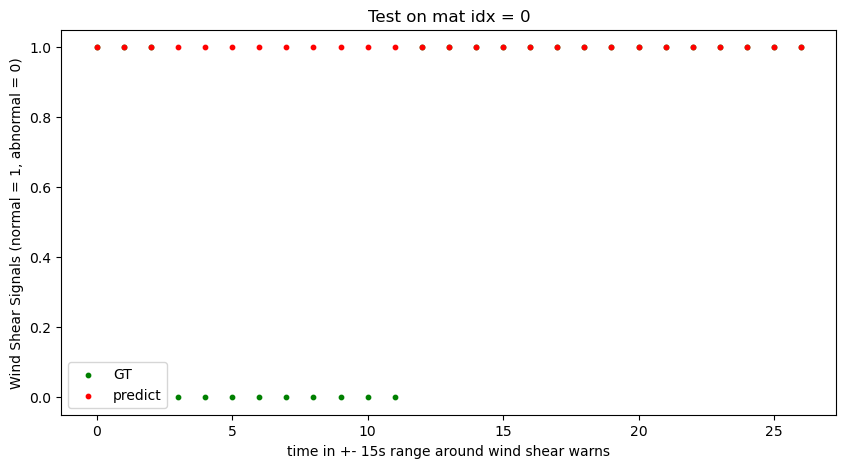

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


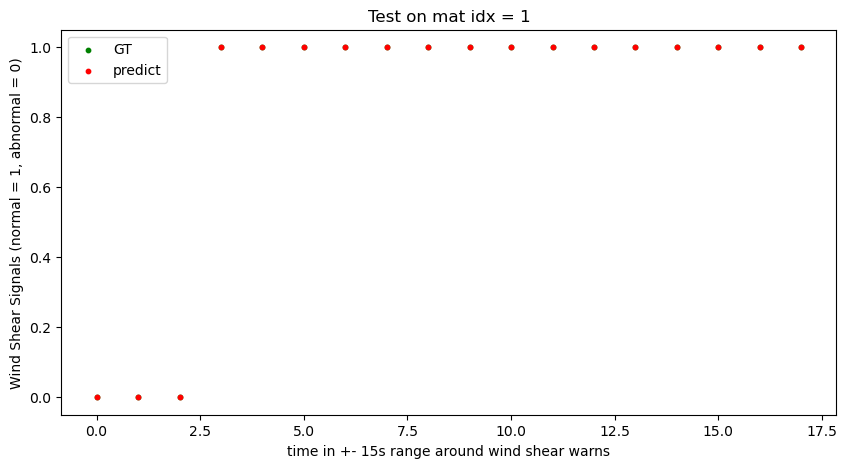

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


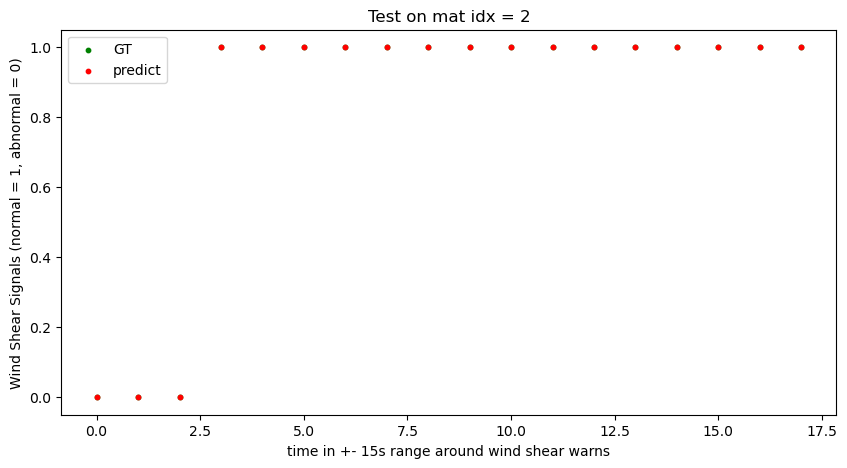

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


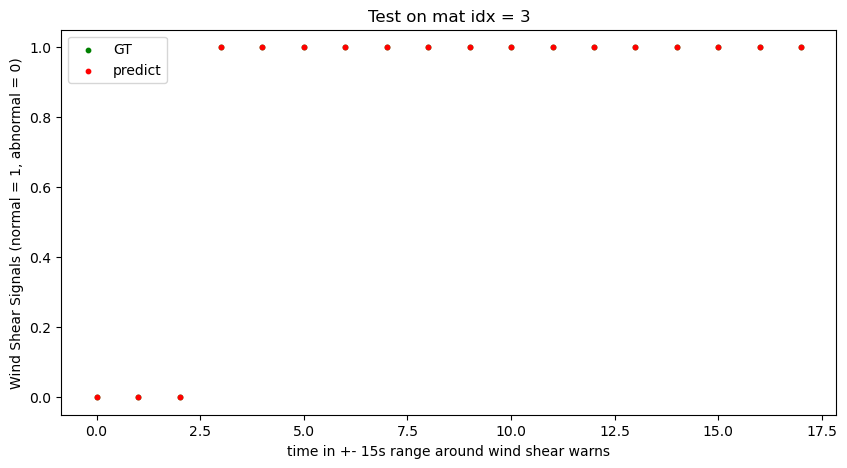

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


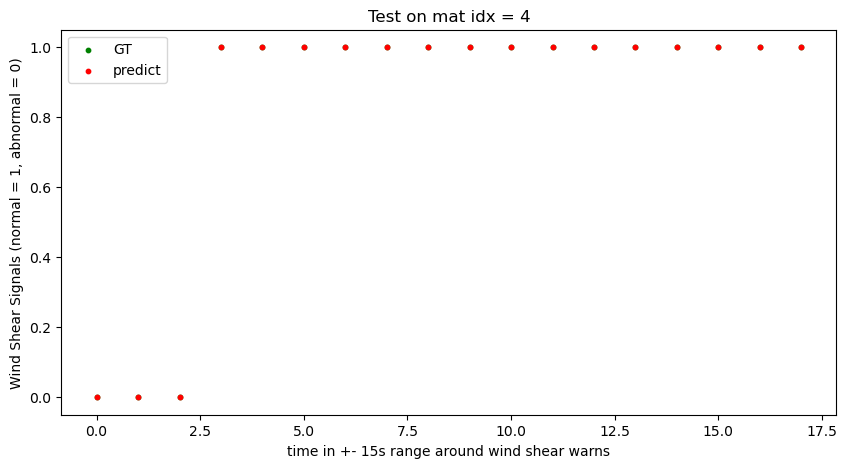

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


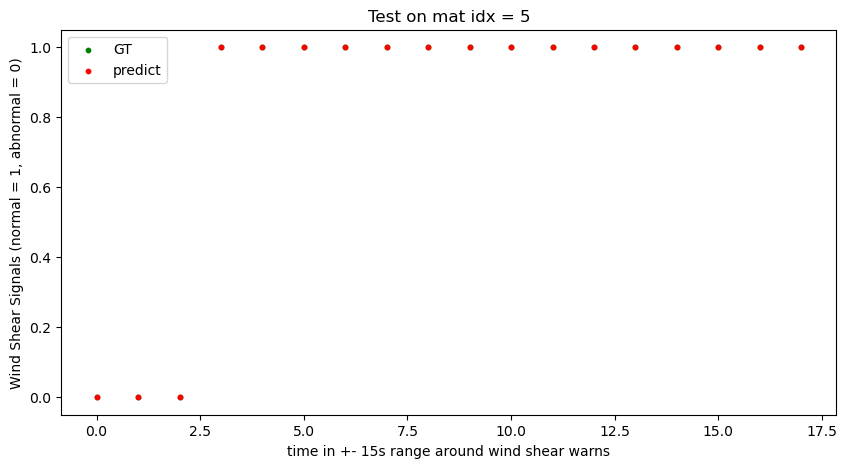

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


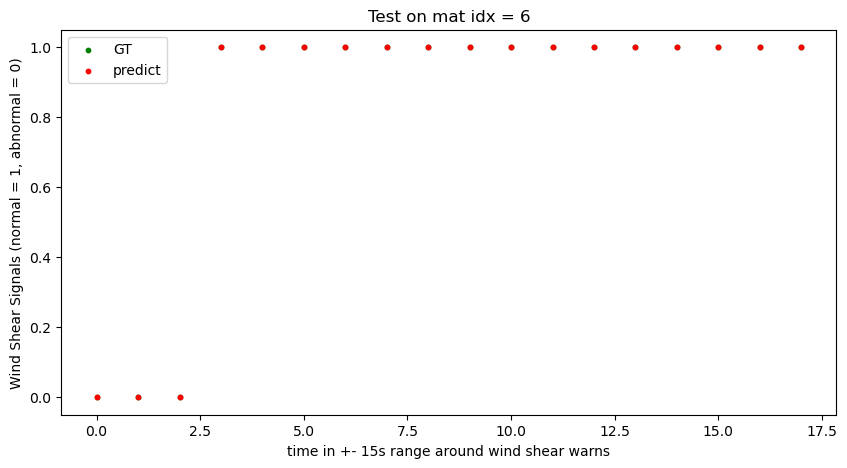

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
(31, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


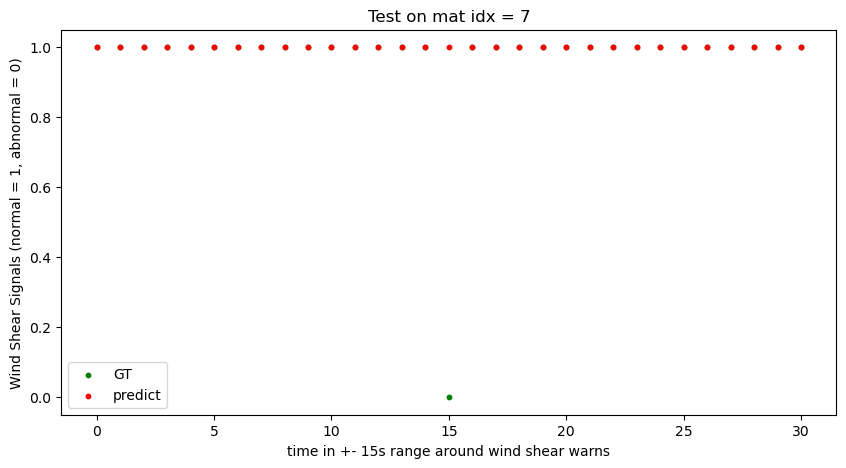

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15 16 17 18 19 20]
(36, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


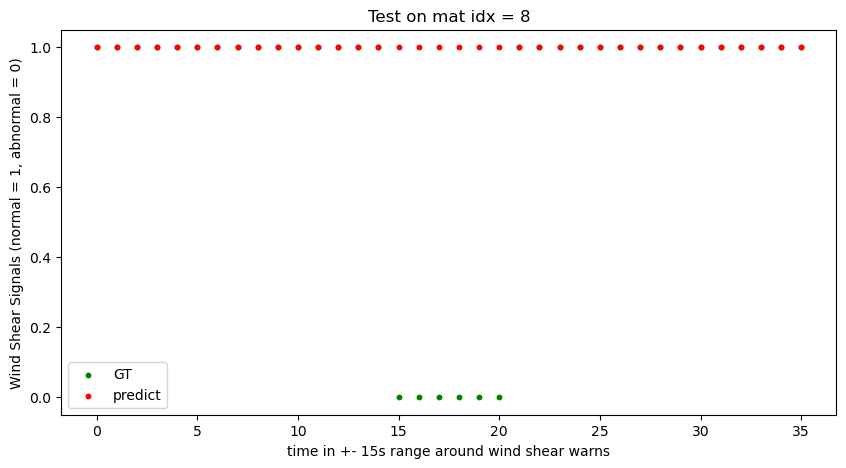

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


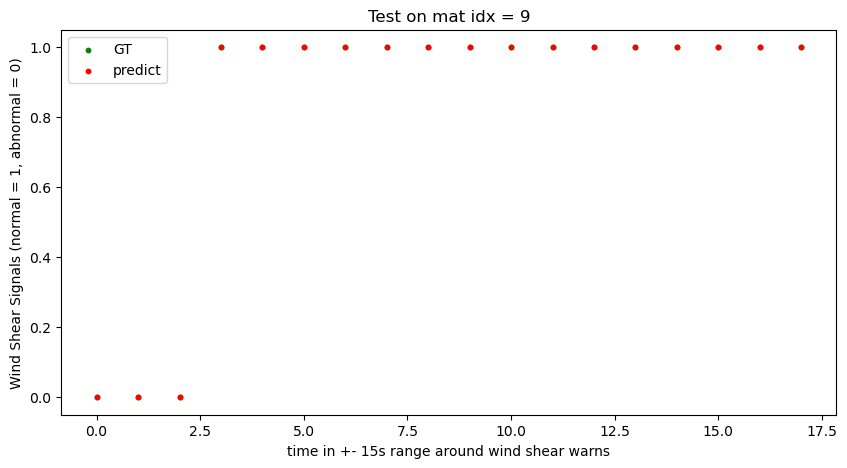

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


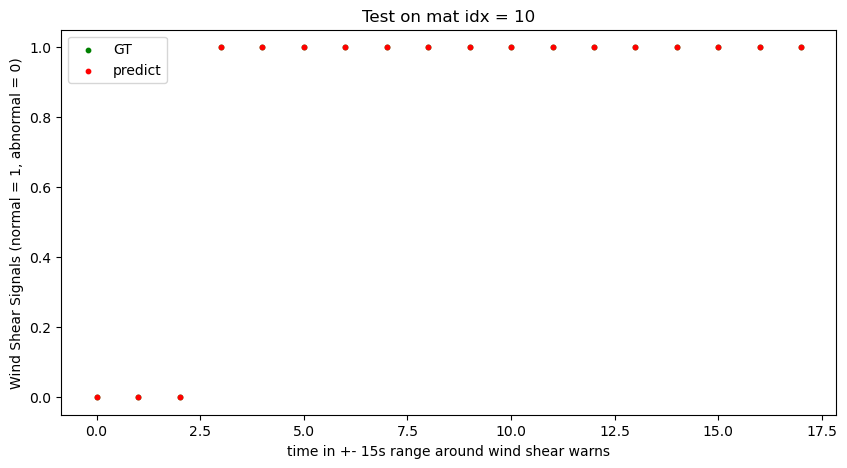

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
(16, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


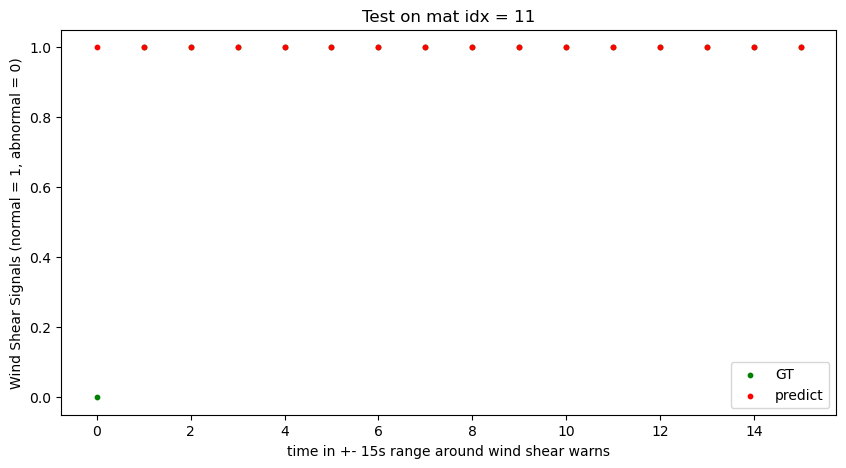

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


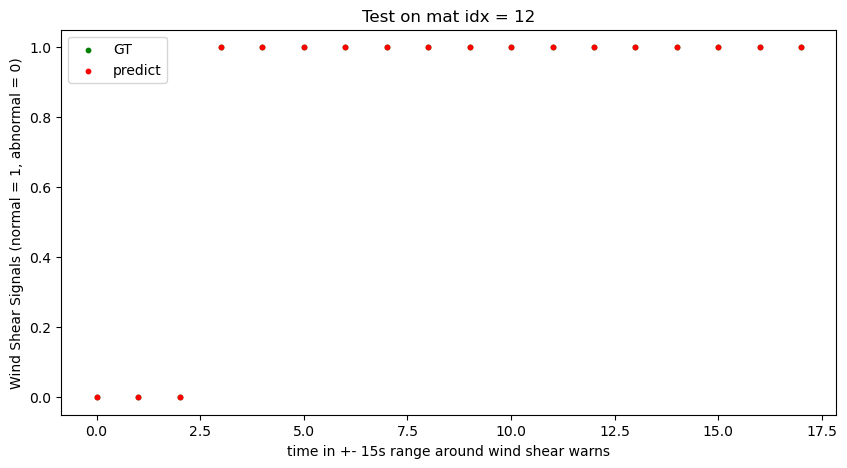

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


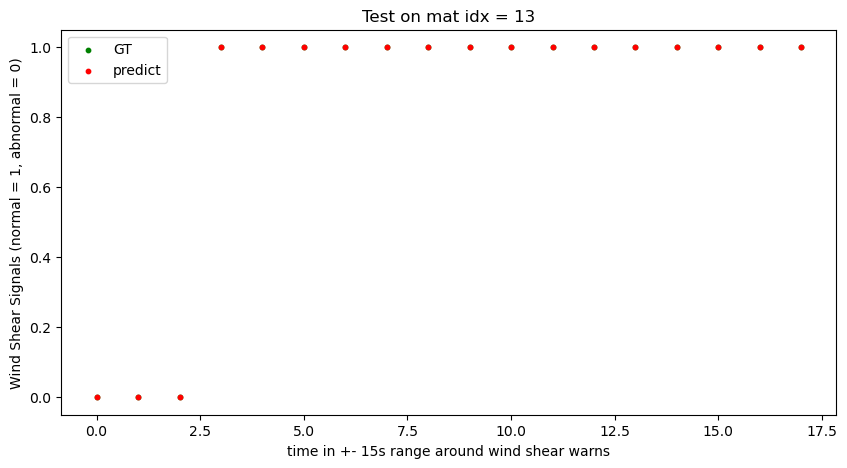

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


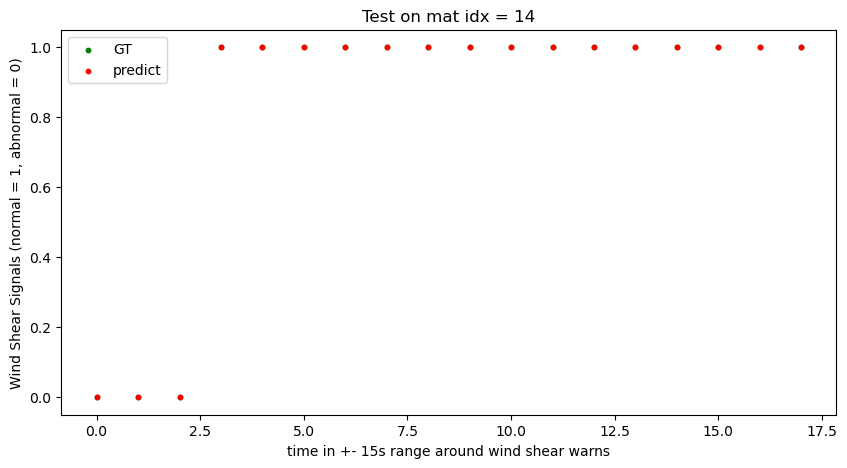

Wind Shear Warns at time [ 3  4  5  6  7  8  9 10 11]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [15]
Wind Shear Warns at time [15 16 17 18 19 20]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
Wind Shear Warns at time [0 1 2]
(18, 163)


d:\Coding\Anaconda\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


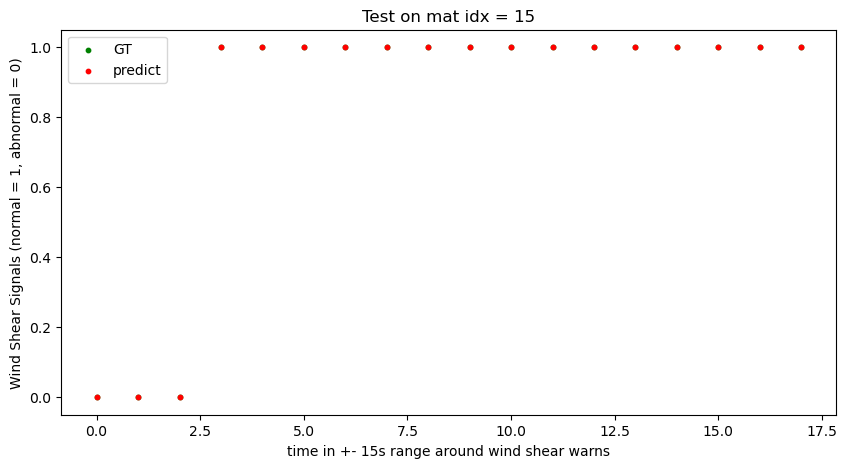

In [9]:
# K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier

for test_idx in range(len(os.listdir(exception_folder_paths[0]))):
    # 数据集构建
    train_X_all, train_Y_all = [], []
    for i, mat_name in enumerate(os.listdir(exception_folder_paths[0])):
        if i == test_idx:
            continue
        # print(mat_name)
        train_X, train_Y = dataConstruct_2(exception_folder_paths[0], mat_name, is_all_variable=True)
        train_X_all.append(train_X)
        train_Y_all.append(train_Y)

    train_X, train_Y = np.concatenate(train_X_all, axis=0), np.concatenate(train_Y_all, axis=0)
    test_X, test_Y = dataConstruct_2(exception_folder_paths[0], os.listdir(exception_folder_paths[0])[test_idx], is_all_variable=True)
    print(test_X.shape)

    # knn模型构建
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_X, train_Y.astype('int'))
    y_pred = knn.predict(test_X)

    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(test_Y)), test_Y, c='g', s=10, label='GT')
    plt.scatter(range(len(y_pred)), y_pred, c='r', s=10, label='predict')
    plt.title(f'Test on mat idx = {test_idx}')
    plt.xlabel('time in +- 15s range around wind shear warns')
    plt.ylabel('Wind Shear Signals (normal = 1, abnormal = 0)')
    plt.legend()
    plt.show()